In [3]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

# read all of the data (STL 10) https://github.com/mttk/STL10
plt.rcParams.update({'font.size': 10})
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show_images(data,row=1,col=1):
    fig=plt.figure(figsize=(10,10))
    columns = col; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
    plt.show()

train_images = read_all_images("../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


<ol>
  <li>A: Normal</li>
  <li>B: Drop Out</li>
  <li>C: Adam</li>
  <li>D: Adam + Grad</li>
  <li>E: Adam + Grad + Forward</li>
</ol>

In [17]:
# create the layers and the needed functions
def tf_softmax(x): return tf.nn.softmax(x)
def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg='A',act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.current_case   = which_reg
        
    def getw(self): return self.w
    
    def feedforward(self,input,stride=1,padding='SAME',training_phase=True,std_value=0.0005):
        self.input  = input
        
        if self.current_case == 'B':
            def training_fn():  return tf.nn.dropout(tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding),0.8)
            def  testing_fn():  return tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
            self.layer  = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
            
        elif self.current_case == 'E':
            def training_fn():  return tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
            def  testing_fn():
                sampled_weight = tf.squeeze(tf.distributions.Normal(loc=self.w, scale=std_value).sample(1))
                return tf.nn.conv2d(input,sampled_weight,strides=[1,stride,stride,1],padding=padding) 
            self.layer  = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
            
        else: self.layer = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        
        self.layerA = self.act(self.layer)
        return self.layer, self.layerA
    
    def backprop(self,gradient,std_value,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) 
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)
        
        if self.current_case == 'D' or self.current_case == 'E': grad = tf.squeeze(tf.distributions.Normal(loc=grad, scale=std_value).sample(1))
        
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        
        if self.current_case == 'C' or self.current_case == 'D' or self.current_case == 'E': adam_middle = tf.squeeze(tf.distributions.Normal(loc=adam_middle, scale=std_value).sample(1))
        
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        return grad_pass,grad,update_w
    
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     
def append_stat(current_list,data,number):
    current_list[0].append(data[number].mean())
    current_list[1].append(data[number].std())
    current_list[2].append(skew    (data[number].ravel()))
    current_list[3].append(kurtosis(data[number].ravel()))
    current_list[4].append(np.count_nonzero(data[number]))
    return current_list
def transform_to_2d(data):
    batch,width,height,chan = data.shape
    return data.reshape((batch*width,height*chan))
def save_to_image(main_data,one,two,three,four,five,six,experiment_name,tran_acc,test_acc,current_exp,iter):
    plt.figure(figsize=(20,40))
    G = gridspec.GridSpec(8, 6)

    plt.figtext(0.5,1.0,"Iter: " + str(iter) + " Histogram Per " + experiment_name,ha="center", va="top", fontsize=35, color="black")
    plt.subplot(G[0, 0]).hist(main_data[0].ravel(),50,color='red');       plt.subplot(G[0, 0]).set_title(experiment_name+' 1')
    plt.subplot(G[0, 1]).hist(main_data[1].ravel(),50,color='orange');    plt.subplot(G[0, 1]).set_title(experiment_name+' 2')
    plt.subplot(G[0, 2]).hist(main_data[2].ravel(),50,color='yellow');  plt.subplot(G[0, 2]).set_title(experiment_name+' 3')
    plt.subplot(G[0, 3]).hist(main_data[3].ravel(),50,color='green');    plt.subplot(G[0, 3]).set_title(experiment_name+' 4')
    plt.subplot(G[0, 4]).hist(main_data[4].ravel(),50,color='blue');     plt.subplot(G[0, 4]).set_title(experiment_name+' 5')
    plt.subplot(G[0, 5]).hist(main_data[5].ravel(),50,color='black');     plt.subplot(G[0, 5]).set_title(experiment_name+' 6')

    plt.subplot(G[1, :]).set_title("Mean Per "+ experiment_name)
    plt.subplot(G[1, :]).plot(one[0]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[1, :]).plot(two[0]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[1, :]).plot(three[0],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[1, :]).plot(four[0],c='green',alpha=0.9,label='4')
    plt.subplot(G[1, :]).plot(five[0],c='blue',alpha=0.9,label='5')
    plt.subplot(G[1, :]).plot(six[0],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[2, :]).set_title("Standard Deviation Per "+ experiment_name)
    plt.subplot(G[2, :]).plot(one[1]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[2, :]).plot(two[1]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[2, :]).plot(three[1],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[2, :]).plot(four[1],c='green',alpha=0.9,label='4')
    plt.subplot(G[2, :]).plot(five[1],c='blue',alpha=0.9,label='5')
    plt.subplot(G[2, :]).plot(six[1],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[3, :]).set_title("Skewness Per "+ experiment_name)
    plt.subplot(G[3, :]).plot(one[2]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[3, :]).plot(two[2]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[3, :]).plot(three[2],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[3, :]).plot(four[2],c='green',alpha=0.9,label='4')
    plt.subplot(G[3, :]).plot(five[2],c='blue',alpha=0.9,label='5')
    plt.subplot(G[3, :]).plot(six[2],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[4, :]).set_title("Kurtosis Per "+ experiment_name)
    plt.subplot(G[4, :]).plot(one[3]  ,c='red',alpha=0.9,label='1')
    plt.subplot(G[4, :]).plot(two[3]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[4, :]).plot(three[3],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[4, :]).plot(four[3],c='green',alpha=0.9,label='4')
    plt.subplot(G[4, :]).plot(five[3],c='blue',alpha=0.9,label='5')
    plt.subplot(G[4, :]).plot(six[3],c='black',alpha=0.9,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[5, :]).set_title("# Non-Zero Per "+ experiment_name)
    plt.subplot(G[5, :]).plot(one[4]  ,c='red',alpha=0.9   ,label='1')
    plt.subplot(G[5, :]).plot(two[4]  ,c='orange',alpha=0.9,label='2')
    plt.subplot(G[5, :]).plot(three[4],c='yellow',alpha=0.9,label='3')
    plt.subplot(G[5, :]).plot(four[4],c='green',alpha=0.9  ,label='4')
    plt.subplot(G[5, :]).plot(five[4],c='blue',alpha=0.9   ,label='5')
    plt.subplot(G[5, :]).plot(six[4],c='black',alpha=0.9   ,label='6')
    plt.legend(bbox_to_anchor=(0., 0.95, 1., .05), loc=9,ncol=6, mode="expand", borderaxespad=0.)

    plt.subplot(G[6, :]).set_title("Train/Test accuracy")
    plt.subplot(G[6, :]).plot(train_acc  ,c='red',alpha=0.9, label='Train')
    plt.subplot(G[6, :]).plot(test_acc   ,c='blue',alpha=0.9,label='Test')
    plt.legend()

    plt.figtext(0.5,0,"Correlation Matrix Per "+ experiment_name,ha="center", va="bottom", fontsize=30, color="black")
    plt.subplot(G[7, 0]).imshow(np.corrcoef(transform_to_2d(main_data[0])),cmap='gray')
    plt.subplot(G[7, 1]).imshow(np.corrcoef(transform_to_2d(main_data[1])),cmap='gray')
    plt.subplot(G[7, 2]).imshow(np.corrcoef(transform_to_2d(main_data[2])),cmap='gray')
    plt.subplot(G[7, 3]).imshow(np.corrcoef(transform_to_2d(main_data[3])),cmap='gray')
    plt.subplot(G[7, 4]).imshow(np.corrcoef(transform_to_2d(main_data[4])),cmap='gray')
    plt.subplot(G[7, 5]).imshow(np.corrcoef(transform_to_2d(main_data[5])),cmap='gray')

    plt.tight_layout()
    plt.savefig(current_exp + '/' + experiment_name + '/' + str(iter) + '.png')
    plt.close('all')
def plot_rotation_weight(current_layers,current_layer_number,current_batch_norm_type,current_exp_name): 

    def rotate(angle):ax.view_init(azim=angle)
    plt.rcParams.update({'font.size': 8})
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    number_of_eps = [1,2,3,4,5,6,7,8,9,10,11]
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111, projection='3d')
    count = 0
    for episode in range(num_eps+1):
        if episode == num_eps:
            ys   = current_layers.mean(0).flatten()
            xmin = ys.min(); xmax = ys.max(); step = 0.005
            hist,bins = np.histogram(ys, bins=np.linspace(xmin, xmax, (xmax-xmin)/step))
            ax.bar(bins[:-1], hist, width=0.01,zs=episode, zdir='y', color=colors[episode], alpha=0.8)
        else:
            ys   = current_layers[episode].flatten()
            xmin = ys.min(); xmax = ys.max(); step = 0.005
            hist,bins = np.histogram(ys, bins=np.linspace(xmin, xmax, (xmax-xmin)/step))
            ax.bar(bins[:-1], hist, width=0.01,zs=episode, zdir='y', color=colors[episode], alpha=0.4)
    ax.set_xlabel('Values')
    ax.set_ylabel('Episode')
    ax.get_yaxis().set_ticks(np.arange(num_eps+1))
    ax.set_zlabel('Histogram')

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    #plt.tight_layout()
    plt.show()

    animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=100) \
    .save(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/weight_'+str(current_layer_number)+'.gif', dpi=80, writer='imagemagick')
    plt.close('all')
def plot_image_weight(current_layers,current_layer_number,current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy):
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    def rt(number): return np.around(number,4)
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(15,15))
    plt.rcParams.update({'font.size': 50})

    fig.add_subplot(341); plt.hist(current_layers[0].flatten(),50,color=colors[0],alpha=0.8);plt.title('EPS: 1 Mean: '+str(rt(current_layers[0].mean())) +' STD: '+str(rt(current_layers[0].std())))
    fig.add_subplot(342); plt.hist(current_layers[1].flatten(),50,color=colors[1],alpha=0.8);plt.title('EPS: 2 Mean: '+str(rt(current_layers[1].mean())) +' STD: '+str(rt(current_layers[1].std())))
    fig.add_subplot(343); plt.hist(current_layers[2].flatten(),50,color=colors[2],alpha=0.8);plt.title('EPS: 3 Mean: '+str(rt(current_layers[2].mean())) +' STD: '+str(rt(current_layers[2].std())))
    fig.add_subplot(344); plt.hist(current_layers[3].flatten(),50,color=colors[3],alpha=0.8);plt.title('EPS: 4 Mean: '+str(rt(current_layers[3].mean())) +' STD: '+str(rt(current_layers[3].std())))
    
    fig.add_subplot(345); plt.hist(current_layers[4].flatten(),50,color=colors[4],alpha=0.8);plt.title('EPS: 5 Mean: '+str(rt(current_layers[4].mean())) +' STD: '+str(rt(current_layers[4].std())))
    fig.add_subplot(346); plt.hist(current_layers[5].flatten(),50,color=colors[5],alpha=0.8);plt.title('EPS: 6 Mean: '+str(rt(current_layers[5].mean())) +' STD: '+str(rt(current_layers[5].std())))
    fig.add_subplot(347); plt.hist(current_layers[6].flatten(),50,color=colors[6],alpha=0.8);plt.title('EPS: 7 Mean: '+str(rt(current_layers[6].mean())) +' STD: '+str(rt(current_layers[6].std())))
    fig.add_subplot(348); plt.hist(current_layers[7].flatten(),50,color=colors[7],alpha=0.8);plt.title('EPS: 8 Mean: '+str(rt(current_layers[7].mean())) +' STD: '+str(rt(current_layers[7].std())))
    
    fig.add_subplot(3,4,9);  plt.hist(current_layers[8].flatten(),50,color=colors[8],alpha=0.8);plt.title('EPS: 9 Mean: '+str(rt(current_layers[8].mean())) +' STD: '+str(rt(current_layers[8].std())))
    fig.add_subplot(3,4,10); plt.hist(current_layers[9].flatten(),50,color=colors[9],alpha=0.8);plt.title('EPS: 10 Mean: '+str(rt(current_layers[9].mean())) +' STD: '+str(rt(current_layers[9].std())))
    fig.add_subplot(3,4,11); plt.hist(current_layers.mean(0).flatten(),50,color=colors[10],alpha=0.8);plt.title('EPS: All Mean: '+str(rt(current_layers.mean(0).mean())) +' STD: '+str(rt(current_layers.mean(0).std())))
    fig.add_subplot(3,4,12); 
    plt.plot(current_exp_train_accuracy.max(0),  ' ' ,color='red')
    plt.plot(current_exp_train_accuracy.mean(0), '-' ,color='red',label='train mean')
    plt.plot(current_exp_train_accuracy.min(0) , ' ' ,color='red')
    plt.fill_between(range(num_epoch),current_exp_train_accuracy.max(0),current_exp_train_accuracy.min(0),facecolor='red', alpha=0.2)

    plt.plot(current_exp_test_accuracy.max(0),  ' ' ,color='blue')
    plt.plot(current_exp_test_accuracy.mean(0), '-' ,color='blue',label='test mean')
    plt.plot(current_exp_test_accuracy.min(0) , ' ' ,color='blue')
    plt.fill_between(range(num_epoch),current_exp_test_accuracy.max(0),current_exp_test_accuracy.min(0),facecolor='blue', alpha=0.2)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/weight_'+str(current_layer_number)+'.png')
    plt.close('all')
def plot_full_weight(current_weights_layer1,current_weights_layer2,current_weights_layer3,
                     current_weights_layer4,current_weights_layer5,current_weights_layer6,
                     current_batch_norm_type,current_exp_name,current_exp_train_accuracy,current_exp_test_accuracy):
    
    colors = ['red','orange','yellow','green','blue','purple','black','gold','silver','cyan','pink']
    def rt(number): return np.around(number,4)
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(15,15))
    plt.rcParams.update({'font.size': 50})
    gs = gridspec.GridSpec(3, 3)
    
    fig.add_subplot(331); plt.hist(current_weights_layer1.mean(0).flatten(),50,color=colors[0],alpha=0.8); plt.title('Layer 1 Histogram Mean :'+str(rt(current_weights_layer1.mean(0).mean()))+' STD: '+str(rt(current_weights_layer1.mean(0).std())))
    fig.add_subplot(332); plt.hist(current_weights_layer2.mean(0).flatten(),50,color=colors[1],alpha=0.8); plt.title('Layer 2 Histogram Mean :'+str(rt(current_weights_layer2.mean(0).mean()))+' STD: '+str(rt(current_weights_layer2.mean(0).std())))
    fig.add_subplot(333); plt.hist(current_weights_layer3.mean(0).flatten(),50,color=colors[2],alpha=0.8); plt.title('Layer 3 Histogram Mean :'+str(rt(current_weights_layer3.mean(0).mean()))+' STD: '+str(rt(current_weights_layer3.mean(0).std())))
    
    fig.add_subplot(334); plt.hist(current_weights_layer4.mean(0).flatten(),50,color=colors[3],alpha=0.8); plt.title('Layer 4 Histogram Mean :'+str(rt(current_weights_layer4.mean(0).mean()))+' STD: '+str(rt(current_weights_layer4.mean(0).std())))
    fig.add_subplot(335); plt.hist(current_weights_layer5.mean(0).flatten(),50,color=colors[4],alpha=0.8); plt.title('Layer 5 Histogram Mean :'+str(rt(current_weights_layer5.mean(0).mean()))+' STD: '+str(rt(current_weights_layer5.mean(0).std())))
    fig.add_subplot(336); plt.hist(current_weights_layer6.mean(0).flatten(),50,color=colors[5],alpha=0.8); plt.title('Layer 6 Histogram Mean :'+str(rt(current_weights_layer6.mean(0).mean()))+' STD: '+str(rt(current_weights_layer6.mean(0).std())))
    
    fig.add_subplot(gs[2,:]); 
    plt.plot(current_exp_train_accuracy.max(0),  ' ' ,color='red')
    plt.plot(current_exp_train_accuracy.mean(0), '-' ,color='red',label='train mean')
    plt.plot(current_exp_train_accuracy.min(0) , ' ' ,color='red')
    plt.fill_between(range(num_epoch),current_exp_train_accuracy.max(0),current_exp_train_accuracy.min(0),facecolor='red', alpha=0.2)

    plt.plot(current_exp_test_accuracy.max(0),  ' ' ,color='blue')
    plt.plot(current_exp_test_accuracy.mean(0), '-' ,color='blue',label='test mean')
    plt.plot(current_exp_test_accuracy.min(0) , ' ' ,color='blue')
    plt.fill_between(range(num_epoch),current_exp_test_accuracy.max(0),current_exp_test_accuracy.min(0),facecolor='blue', alpha=0.2)
    
    plt.tight_layout()
    plt.legend()
    plt.savefig(str(current_batch_norm_type)+'/'+str(current_exp_name)+'/z_all.png')
    plt.close('all')
def send_notification_email(letter,episode):
    import smtplib, ssl

    port = 587  # For starttls
    smtp_server = "smtp.gmail.com"
    sender_email = "sendresultsforme@gmail.com"
    receiver_email = "jae.duk.seo@gmail.com"
    password = "Password123*"
    message = "Subject: " + str(letter) + " : "+str(episode)+" is done!"

    context = ssl.create_default_context()
    with smtplib.SMTP(smtp_server, port) as server:
        server.ehlo()  # Can be omitted
        server.starttls(context=context)
        server.ehlo()  # Can be omitted
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)

In [18]:
# set hyper parameter
plt.rcParams.update({'font.size': 25})
num_eps   = 20; num_epoch = 350; learning_rate = 0.0008; batch_size = 100; 
beta1,beta2,adam_e = 0.9,0.999,1e-9; 
print_iter = 50

In [19]:
# no batch
current_batch_norm_type = 'no_batch'
all_the_exp = ['A','B','C','D','E']

for letter in all_the_exp:
    current_exp_name = letter
    sess = tf.InteractiveSession()
    current_exp_train_accuracy = np.zeros((num_eps,num_epoch))
    current_exp_test_accuracy  = np.zeros((num_eps,num_epoch))
    MAX_STD_VALUE = 0.0005

    for episode in range(num_eps):
        sys.stdout.write("""
        ================================================
                    Starting Episode: """ + str(episode) + " for " + str(letter) + """
        ================================================\n
        """);sys.stdout.flush();

        # create layers
        l1 = CNN(3,3, 16,which_reg=letter); l2 = CNN(3,16,16,which_reg=letter); l3 = CNN(3,16,16,which_reg=letter); 
        l4 = CNN(3,16,16,which_reg=letter); l5 = CNN(3,16,16,which_reg=letter); l6 = CNN(3,16,10,which_reg=letter); 

        # 2. graph 
        x = tf.placeholder(tf.float32,(batch_size,96,96,3))
        y = tf.placeholder(tf.float32,(batch_size,10))
        is_train  = tf.placeholder_with_default(True,())
        std_value = tf.placeholder(tf.float32)

        layer1, layer1a = l1. feedforward(x,stride=2,training_phase=is_train,std_value=std_value)
        layer2, layer2a = l2. feedforward(layer1a,stride=2,training_phase=is_train,std_value=std_value)
        layer3, layer3a = l3. feedforward(layer2a,stride=2,training_phase=is_train,std_value=std_value)
        layer4, layer4a = l4. feedforward(layer3a,stride=2,training_phase=is_train,std_value=std_value)
        layer5, layer5a = l5. feedforward(layer4a,training_phase=is_train,std_value=std_value)
        layer6, layer6a = l6. feedforward(layer5a,training_phase=is_train,std_value=std_value)

        final_layer   = tf.reduce_mean(layer6a,(1,2))
        final_softmax = tf_softmax(final_layer)
        cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
        correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
        accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
        grad6p,grad6w,grad6_up = l6.backprop(gradient,std_value=std_value)
        grad5p,grad5w,grad5_up = l5.backprop(grad6p,std_value=std_value)
        grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2,std_value=std_value)
        grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2,std_value=std_value)
        grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2,std_value=std_value)
        grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2,std_value=std_value)

        gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

        # train
        sess.run(tf.global_variables_initializer())
        avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []

        for iter in range(num_epoch):

            current_std_value = MAX_STD_VALUE

            # Training Accuracy    
            for current_batch_index in range(0,len(train_images),batch_size):
                current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label,std_value:current_std_value})
                sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + 
                                 '\tbatch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + 
                                 '\tacc : ' + str(sess_results[0]) +
                                 '\tstd  : ' + str(current_std_value) +
                                 '\r')
                sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

            # Test Accuracy    
            for current_batch_index in range(0,len(test_images), batch_size):
                current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
                sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False,std_value:current_std_value})
                sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + 
                                 '\tbatch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + 
                                 '\tacc : ' + str(sess_results[0]) + 
                                 '\tstd  : ' + str(current_std_value) +
                                 '\r')
                sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   

            # ======================== print reset ========================
            train_acc.append(avg_acc_train/(len(train_images)/batch_size))
            test_acc .append(avg_acc_test / (len(test_images)/batch_size))
            if iter%print_iter == 0 or iter==num_epoch-1 :
                sys.stdout.write("Current : "+ str(iter) + "\t" +
                      " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size),3)) + "\t" +
                      " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) +  "\t" +
                      " STD : "  + str(current_std_value) + 
                      "\t\n")
                sys.stdout.flush();
            avg_acc_train = 0 ; avg_acc_test  = 0
            # ======================== print reset ========================
            
        # save the file
        current_exp_train_accuracy[episode,:] = train_acc
        current_exp_test_accuracy [episode,:] = test_acc
        send_notification_email(letter,episode)
        
    # close the session and save
    sess.close()
    
    # save to the file
    np.save(str(current_batch_norm_type)+'/'+str(letter)+'/train.npy', current_exp_train_accuracy)
    np.save(str(current_batch_norm_type)+'/'+str(letter)+'/test.npy', current_exp_test_accuracy)
    print(current_exp_train_accuracy.shape,current_exp_train_accuracy.mean())
    print(current_exp_test_accuracy.shape,current_exp_test_accuracy.mean())



                    Starting Episode: 0 for A

Current : 0	 Train Acc : 0.099	 Test Acc : 0.1	 STD : 0.0005	55.0005
Current : 10	 Train Acc : 0.278	 Test Acc : 0.275	 STD : 0.0005	
Current : 20	 Train Acc : 0.322	 Test Acc : 0.301	 STD : 0.0005	
Current : 30	 Train Acc : 0.345	 Test Acc : 0.33	 STD : 0.0005	5
Current : 40	 Train Acc : 0.364	 Test Acc : 0.351	 STD : 0.0005	
Current : 49	 Train Acc : 0.38	 Test Acc : 0.359	 STD : 0.0005	5

                    Starting Episode: 0 for B

Current : 0	 Train Acc : 0.095	 Test Acc : 0.1	 STD : 0.0005	55.0005
Current : 10	 Train Acc : 0.219	 Test Acc : 0.245	 STD : 0.0005	
Current : 20	 Train Acc : 0.252	 Test Acc : 0.273	 STD : 0.0005	
Current : 30	 Train Acc : 0.259	 Test Acc : 0.304	 STD : 0.0005	
Current : 40	 Train Acc : 0.271	 Test Acc : 0.316	 STD : 0.0005	
Current : 49	 Train Acc : 0.286	 Test Acc : 0.33	 STD : 0.0005	5

                    Starting Episode: 0 for C

Current : 0	 Train Acc : 0.115	 Test Acc : 0.154	 STD : 0.0005	.0005

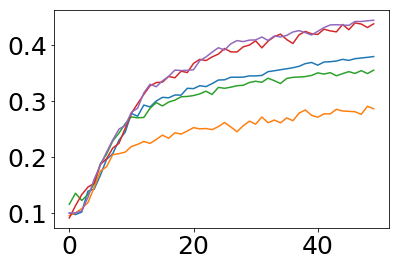

In [27]:
a_train = np.load('no_batch/A/train.npy')
a_test  = np.load('no_batch/A/test.npy .npy')
b_train = np.load('no_batch/B/train.npy')
b_test  = np.load('no_batch/B/test.npy .npy')
c_train = np.load('no_batch/C/train.npy')
c_test  = np.load('no_batch/C/test.npy .npy')
d_train = np.load('no_batch/D/train.npy')
d_test  = np.load('no_batch/D/test.npy .npy')
e_train = np.load('no_batch/E/train.npy')
e_test  = np.load('no_batch/E/test.npy .npy')

plt.plot(a_train[0])
plt.plot(b_train[0])
plt.plot(c_train[0])
plt.plot(d_train[0])
plt.plot(e_train[0])
plt.show()

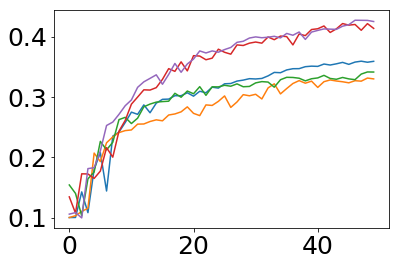

In [28]:
plt.plot(a_test[0])
plt.plot(b_test[0])
plt.plot(c_test[0])
plt.plot(d_test[0])
plt.plot(e_test[0])
plt.show()

In [21]:
! start .